In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pylab import rcParams
from scipy import stats

import pingouin as pg

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

In [16]:
# Selected recipes
s1 = pd.read_csv("./Pro_1/selectedrecipes.csv")
s2 = pd.read_csv("./Pro_2/selectedrecipes.csv")
s3 = pd.read_csv("./Pro_3/selectedrecipes.csv")


# Demographic
demo1 = pd.read_csv("./Pro_1/demographics.csv")
demo2 = pd.read_csv("./Pro_2/demographics.csv")
demo3 = pd.read_csv("./Pro_3/demographics.csv")
md = pd.concat([demo1, demo2, demo3])

In [17]:
# Calculate mean for choice difficulty for each participant (DROP QUESTION 5: "5. It was easy to make this choice")
choice_dif1 = s1[["choice_sat_q4", "choice_sat_q6"]]
s1['choice_dif_mean'] = choice_dif1.mean(axis=1)

choice_dif2 = s2[["choice_sat_q4", "choice_sat_q6"]]
s2['choice_dif_mean'] = choice_dif2.mean(axis=1)

choice_dif3 = s3[["choice_sat_q4", "choice_sat_q6"]]
s3['choice_dif_mean'] = choice_dif3.mean(axis=1)

In [18]:
# Add all data to one DF
ms = pd.concat([s1, s2, s3])

# Balance data (remove where user_id only selected 2 recipes)
ms = ms[ms['user_id'].map(ms['user_id'].value_counts()) > 2]

In [19]:
# Create a new column with names for each label
def label_name (row):
    if row['condition'] == 1 :
        return 'Nutriscore'
    if row['condition'] == 2 :
        return 'MTL'
    if row['condition'] == 3 :
        return 'No-label'

def rank_name (row):
    if row['variant'] == 1 :
        return 'Popular'
    if row['variant'] == 2 :
        return 'Random'
    if row['variant'] == 3 :
        return 'Health'

def numeric_nutriscore (row):
    if row['nutri_score'] == 'A' :
        return 1
    if row['nutri_score'] == 'B' :
        return 2
    if row['nutri_score'] == 'C' :
        return 3
    if row['nutri_score'] == 'D' :
        return 4
    if row['nutri_score'] == 'E' :
        return 5


ms['Label'] = ms.apply(lambda row: label_name(row), axis=1)
ms['Rank'] = ms.apply(lambda row: rank_name(row), axis=1)
ms['num_nutriscore'] = ms.apply(lambda row: numeric_nutriscore(row), axis=1)

In [20]:
# Take the mean of the 3 choice difficulty questions for each participant
shown1 = s1
shown2 = s2
shown3 = s3 

# Condition 1 variants
s1v1 = shown1.loc[shown1['variant'] == 1]
s1v2 = shown1.loc[shown1['variant'] == 2] 
s1v3 = shown1.loc[shown1['variant'] == 3]

# Condition 2 variants
s2v1 = shown2.loc[shown2['variant'] == 1]
s2v2 = shown2.loc[shown2['variant'] == 2]
s2v3 = shown2.loc[shown2['variant'] == 3]

# Condition 3 variants
s3v1 = shown3.loc[shown3['variant'] == 1]
s3v2 = shown3.loc[shown3['variant'] == 2]
s3v3 = shown3.loc[shown3['variant'] == 3]

h1 = s1v3['choice_dif_mean'].to_numpy()
h2 = s2v3['choice_dif_mean'].to_numpy()
h3 = s3v3['choice_dif_mean'].to_numpy()

r1 = s1v2['choice_dif_mean'].to_numpy()
r2 = s2v2['choice_dif_mean'].to_numpy()
r3 = s3v2['choice_dif_mean'].to_numpy()

p1 = s1v1['choice_dif_mean'].to_numpy()
p2 = s2v1['choice_dif_mean'].to_numpy()
p3 = s3v1['choice_dif_mean'].to_numpy()

In [21]:
# Get FSA score for different within-subjects variable EXCLUDE VEGANS
no_veg_id = md['user_id'].loc[md['restrictions'] != "vegan"].values

s1_no_veg = s1[s1['user_id'].isin(no_veg_id)]
s2_no_veg = s2[s2['user_id'].isin(no_veg_id)]
s3_no_veg = s3[s3['user_id'].isin(no_veg_id)]

# Add all data to one DF
ms_no_veg = pd.concat([s1_no_veg, s2_no_veg, s3_no_veg])
df_no_veg = ms_no_veg[['user_id', 'fsa_score', 'variant', 'condition', 'who_score', 'nutri_score', 'choice_dif_mean']]


In [22]:
# Get FSA score for different within-subjects variable EXCLUDE ALLERGIES
no_allerg_id = md['user_id'].loc[md['restrictions'] != "allergies"].values

s1_no_allerg = s1[s1['user_id'].isin(no_allerg_id)]
s2_no_allerg = s2[s2['user_id'].isin(no_allerg_id)]
s3_no_allerg = s3[s3['user_id'].isin(no_allerg_id)]

# Add all data to one DF
ms_no_allerg = pd.concat([s1_no_allerg, s2_no_allerg, s3_no_allerg])
df_no_allerg = ms_no_allerg[['user_id', 'fsa_score', 'variant', 'condition', 'who_score', 'nutri_score', 'choice_dif_mean']]


In [23]:
# Divide dataset by cooking experience (Low, Medium, High)
c1 = md['user_id'].loc[md['experience'] == "cverylow"].values
c2 = md['user_id'].loc[md['experience'] == "clow"].values
c3 = md['user_id'].loc[md['experience'] == "cmedium"].values
c4 = md['user_id'].loc[md['experience'] == "chigh"].values
c5 = md['user_id'].loc[md['experience'] == "cveryhigh"].values

low = np.concatenate((c1, c2))
medium = c3
high = np.concatenate((c4, c5))

low_cooking = ms[ms['user_id'].isin(low)]
medium_cooking = ms[ms['user_id'].isin(medium)]
high_cooking = ms[ms['user_id'].isin(high)]

In [24]:
e1 = md['user_id'].loc[md['education'] == 1].values
e2 = md['user_id'].loc[md['education'] == 2].values
e3 = md['user_id'].loc[md['education'] == 3].values
e4 = md['user_id'].loc[md['education'] == 4].values
e5 = md['user_id'].loc[md['education'] == 5].values
# Prefer not say: e6 = md['user_id'].loc[md['education'] == 6].values

less_high = ms[ms['user_id'].isin(e1)] # 
high = ms[ms['user_id'].isin(e2)]
bachelor = ms[ms['user_id'].isin(e3)]
master = ms[ms['user_id'].isin(e4)]
doc = ms[ms['user_id'].isin(e5)]

low = np.concatenate((e1,e2))
medium = e3
high = np.concatenate((e4,e5))

low_edu = ms[ms['user_id'].isin(low)]
bach_edu = ms[ms['user_id'].isin(medium)]
high_edu = ms[ms['user_id'].isin(high)]

In [25]:
# Eating habits
h1 = md['user_id'].loc[md['eating_habits'] == "vunhealthy"].values
h2 = md['user_id'].loc[md['eating_habits'] == "unhealthy"].values
h3 = md['user_id'].loc[md['eating_habits'] == "neutral"].values
h4 = md['user_id'].loc[md['eating_habits'] == "healthy"].values
h5 = md['user_id'].loc[md['eating_habits'] == "vhealhty"].values

pr = ms[ms['user_id'].isin(h1)]
sa = ms[ms['user_id'].isin(h2)]
fr = ms[ms['user_id'].isin(h3)]
vg = ms[ms['user_id'].isin(h4)]
lwe = ms[ms['user_id'].isin(h5)]


unhealthy = np.concatenate((h1, h2))
neutral = h3
healthy = np.concatenate((h4,h5))

unhealthy = ms[ms['user_id'].isin(unhealthy)]
neutral = ms[ms['user_id'].isin(neutral)]
healthy = ms[ms['user_id'].isin(healthy)]

In [26]:
# Dietary goals
"""
6. Do you have any dietary goals? *
 Eat more protein

 Eat less salt

 Eat more fruit

 Eat more vegetables

 Lose weight

 Gain weight

 No goals
 """
g1 = md['user_id'].loc[md['goal'] == "protein"].values
g2 = md['user_id'].loc[md['goal'] == "salt"].values
g3 = md['user_id'].loc[md['goal'] == "fruit"].values
g4 = md['user_id'].loc[md['goal'] == "vegetables"].values
g5 = md['user_id'].loc[md['goal'] == "lweight"].values
g6 = md['user_id'].loc[md['goal'] == "gweight"].values
g7 = md['user_id'].loc[md['goal'] == "none"].values

pr = ms[ms['user_id'].isin(g1)]
sa = ms[ms['user_id'].isin(g1)]
fr = ms[ms['user_id'].isin(g3)]
vg = ms[ms['user_id'].isin(g4)]
lwe = ms[ms['user_id'].isin(g5)]
gwe = ms[ms['user_id'].isin(g6)]
none = ms[ms['user_id'].isin(g7)]


more = np.concatenate((g1, g3,g4,g6)) 
no_goal = g7
reduce = np.concatenate((g2,g5))

more = ms[ms['user_id'].isin(more)]
no_goal = ms[ms['user_id'].isin(no_goal)]
reduce = ms[ms['user_id'].isin(reduce)]

In [27]:
# Divide dataset by cooking experience (Low, Medium, High)
c1 = md['user_id'].loc[md['experience'] == "cverylow"].values
c2 = md['user_id'].loc[md['experience'] == "clow"].values
c3 = md['user_id'].loc[md['experience'] == "cmedium"].values
c4 = md['user_id'].loc[md['experience'] == "chigh"].values
c5 = md['user_id'].loc[md['experience'] == "cveryhigh"].values

low = np.concatenate((c1, c2))
medium = c3
high = np.concatenate((c4, c5))

low_cooking = ms[ms['user_id'].isin(low)]
medium_cooking = ms[ms['user_id'].isin(medium)]
high_cooking = ms[ms['user_id'].isin(high)]

e1 = md['user_id'].loc[md['education'] == 1].values
e2 = md['user_id'].loc[md['education'] == 2].values
e3 = md['user_id'].loc[md['education'] == 3].values
e4 = md['user_id'].loc[md['education'] == 4].values
e5 = md['user_id'].loc[md['education'] == 5].values
# Prefer not say: e6 = md['user_id'].loc[md['education'] == 6].values

less_high = ms[ms['user_id'].isin(e1)] # 
high = ms[ms['user_id'].isin(e2)]
bachelor = ms[ms['user_id'].isin(e3)]
master = ms[ms['user_id'].isin(e4)]
doc = ms[ms['user_id'].isin(e5)]

low = np.concatenate((e1,e2))
medium = e3
high = np.concatenate((e4,e5))

low_edu = ms[ms['user_id'].isin(low)]
bach_edu = ms[ms['user_id'].isin(medium)]
high_edu = ms[ms['user_id'].isin(high)]

# Eating habits
h1 = md['user_id'].loc[md['eating_habits'] == "vunhealthy"].values
h2 = md['user_id'].loc[md['eating_habits'] == "unhealthy"].values
h3 = md['user_id'].loc[md['eating_habits'] == "neutral"].values
h4 = md['user_id'].loc[md['eating_habits'] == "healthy"].values
h5 = md['user_id'].loc[md['eating_habits'] == "vhealhty"].values

pr = ms[ms['user_id'].isin(h1)]
sa = ms[ms['user_id'].isin(h2)]
fr = ms[ms['user_id'].isin(h3)]
vg = ms[ms['user_id'].isin(h4)]
lwe = ms[ms['user_id'].isin(h5)]


unhealthy = np.concatenate((h1, h2))
neutral = h3
healthy = np.concatenate((h4,h5))

unhealthy = ms[ms['user_id'].isin(unhealthy)]
neutral = ms[ms['user_id'].isin(neutral)]
healthy = ms[ms['user_id'].isin(healthy)]

# Dietary goals
"""
6. Do you have any dietary goals? *
 Eat more protein

 Eat less salt

 Eat more fruit

 Eat more vegetables

 Lose weight

 Gain weight

 No goals
 """
g1 = md['user_id'].loc[md['goal'] == "protein"].values
g2 = md['user_id'].loc[md['goal'] == "salt"].values
g3 = md['user_id'].loc[md['goal'] == "fruit"].values
g4 = md['user_id'].loc[md['goal'] == "vegetables"].values
g5 = md['user_id'].loc[md['goal'] == "lweight"].values
g6 = md['user_id'].loc[md['goal'] == "gweight"].values
g7 = md['user_id'].loc[md['goal'] == "none"].values

pr = ms[ms['user_id'].isin(g1)]
sa = ms[ms['user_id'].isin(g1)]
fr = ms[ms['user_id'].isin(g3)]
vg = ms[ms['user_id'].isin(g4)]
lwe = ms[ms['user_id'].isin(g5)]
gwe = ms[ms['user_id'].isin(g6)]
none = ms[ms['user_id'].isin(g7)]


more = np.concatenate((g1, g3,g4,g6)) 
no_goal = g7
reduce = np.concatenate((g2,g5))

more = ms[ms['user_id'].isin(more)]
no_goal = ms[ms['user_id'].isin(no_goal)]
reduce = ms[ms['user_id'].isin(reduce)]

# Factoral analysis
* Determine if we can use the mean of the 3 questions

http://www.let.rug.nl/nerbonne/teach/rema-stats-meth-seminar/student-papers/MHof-QuestionnaireEvaluation-2012-Cronbach-FactAnalysis.pdf

In [29]:
choice_dif = ms[["choice_sat_q4","choice_sat_q5", "choice_sat_q6"]]

kmo_all,kmo_model=calculate_kmo(choice_dif)

fa = FactorAnalyzer(1)
fa.fit(choice_dif)

loadings = pd.DataFrame(fa.loadings_, columns=['Factor 1'], index=choice_dif.columns)
print(kmo_all)
print(kmo_model)
print('Factor Loadings \n%s' %loadings)

loadings = pd.DataFrame(loadings)
loadings
print(loadings.to_latex(index=False))

[0.57668675 0.61013569 0.69981919]
0.613377709097379
Factor Loadings 
               Factor 1
choice_sat_q4  0.935733
choice_sat_q5 -0.634133
choice_sat_q6  0.492727
\begin{tabular}{r}
\toprule
 Factor 1 \\
\midrule
 0.935733 \\
-0.634133 \\
 0.492727 \\
\bottomrule
\end{tabular}



## Cronbach’s Alpha
http://www.let.rug.nl/nerbonne/teach/rema-stats-meth-seminar/student-papers/MHof-QuestionnaireEvaluation-2012-Cronbach-FactAnalysis.pdf

In [48]:
# Choice difficulty questions
choice_dif = ms[["choice_sat_q4","choice_sat_q5", "choice_sat_q6"]]

pg.cronbach_alpha(data=choice_dif)

(-0.6049579165145919, array([-0.727, -0.49 ]))

In [30]:
# Choice difficulty questions -- Remove q5
choice_dif = ms[["choice_sat_q4", "choice_sat_q6"]]
pg.cronbach_alpha(data=choice_dif)

(0.6293225219719272, array([0.596, 0.66 ]))

In [31]:
kmo_all,kmo_model=calculate_kmo(choice_dif)

fa = FactorAnalyzer(1)
fa.fit(choice_dif)

loadings = pd.DataFrame(fa.loadings_, columns=['Factor 1'], index=choice_dif.columns)
print(kmo_all)
print(kmo_model)
print('Factor Loadings \n%s' %loadings)

loadings = pd.DataFrame(loadings)
loadings
print(loadings.to_latex(index=False))

[0.49975979 0.49975979]
0.4997597886278453
Factor Loadings 
               Factor 1
choice_sat_q4  0.679015
choice_sat_q6  0.679015
\begin{tabular}{r}
\toprule
 Factor 1 \\
\midrule
 0.679015 \\
 0.679015 \\
\bottomrule
\end{tabular}



* The alpha coefficient for the two items is .626, suggesting that the items have relatively high internal consistency.  (Note that a reliability coefficient of .70 or higher is considered “acceptable” in most social science research situations.)
    * https://stats.idre.ucla.edu/spss/faq/what-does-cronbachs-alpha-mean/
* The alpha coefficient for the two items is .626, which is not perfect but better than when also including q5. 

In [163]:
ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 707
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2082 non-null   int64  
 1   Unnamed: 0_x             2082 non-null   int64  
 2   user_id                  2082 non-null   int64  
 3   recipe_id                2082 non-null   object 
 4   load_more                420 non-null    object 
 5   recipe_order             2082 non-null   object 
 6   choice_num               2082 non-null   int64  
 7   condition                2082 non-null   int64  
 8   submitted_at             2082 non-null   object 
 9   query_term               2082 non-null   object 
 10  choice_sat_q1            2082 non-null   int64  
 11  choice_sat_q4            2082 non-null   int64  
 12  choice_sat_q2            2082 non-null   int64  
 13  choice_sat_q3            2082 non-null   int64  
 14  choice_sat_q5            

In [162]:
ms.to_csv("ms_choice_dif.csv")

## Desc data

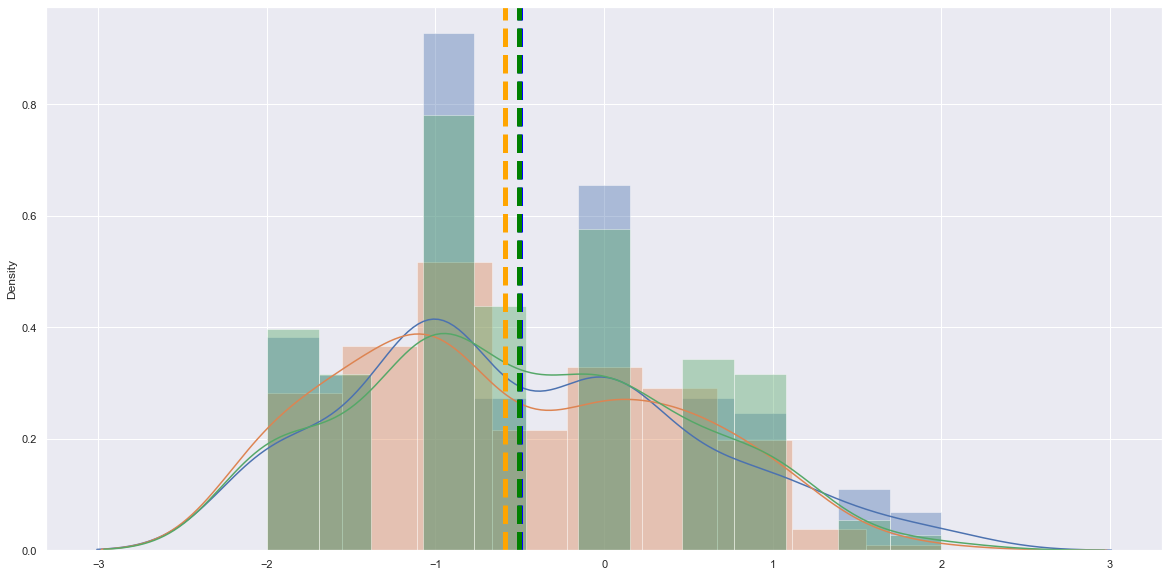

In [57]:
# Compare
plt.figure()
ax1 = sns.distplot(h1)
ax2 = sns.distplot(h2)
ax3 = sns.distplot(h3)
plt.axvline(np.mean(h1), color='blue', linestyle='dashed', linewidth=5)    # Nutri-score health rank
plt.axvline(np.mean(h2), color='orange', linestyle='dashed', linewidth=5)  # MTL health rank
plt.axvline(np.mean(h3), color='green', linestyle='dashed', linewidth=5)   # No-label health rank

In [59]:
# Get mean choice difficulty for different conditions
print("Nutriscore:", stats.describe(s1['choice_dif_mean']), "\n")
print("MTL:", stats.describe(s2['choice_dif_mean']), "\n")
print("No-label:", stats.describe(s3['choice_dif_mean']), "\n")

Nutriscore: DescribeResult(nobs=707, minmax=(-2.0, 2.0), mean=-0.46463932107496464, variance=1.0114957266669604, skewness=0.3639592806640144, kurtosis=-0.5971357472103014) 

MTL: DescribeResult(nobs=717, minmax=(-2.0, 2.0), mean=-0.596931659693166, variance=0.9169179464403979, skewness=0.44322477423287265, kurtosis=-0.5264107970730363) 

No-label: DescribeResult(nobs=708, minmax=(-2.0, 2.0), mean=-0.5635593220338984, variance=0.8417819384844053, skewness=0.39661499221703195, kurtosis=-0.3922441373262431) 



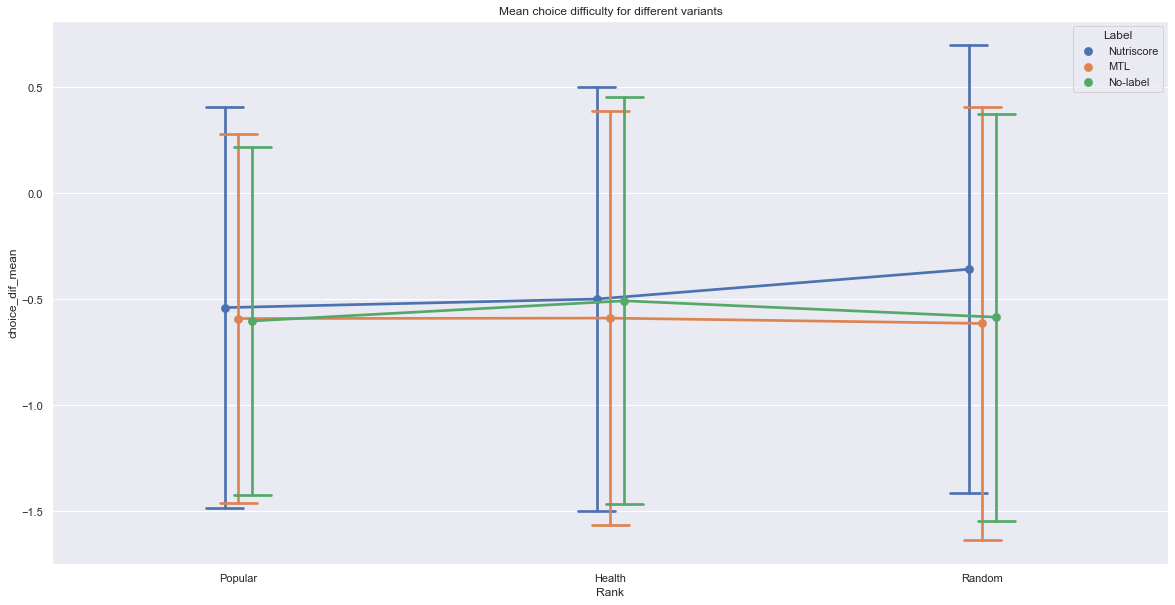

In [74]:
sns.pointplot(data=ms, x='Rank', y='choice_dif_mean', hue='Label', dodge=True, capsize=.1, ci='sd')
#plt.ylim(1, 7)
_ = plt.title('Mean choice difficulty for different variants')

# -2 = low choice dif
# 2 = high choice dif

* High values = high choice difficulty
* Overall choice difficulty was lowest in the MTL condition, and highest in the nutriscore condition.

# RQ2: Can the presence of a front-of-pack nutrition label in combination with a health ranking decrease choice difficulty?

Questions: 
* 4. I changed my mind several times before making a decision
* 5. It was easy to make this choice (this questions was not included) 
* 6. Making a choice was overwhelming

Answers:
* Strongly disagree = -2lowest
* Disagree = 1
* Neither disagree/agree = 0
* Agree = 1
* Strongly agree = 2

Choice difficulty: 
* -2 = Easy to make a choice
* 2 = Hard to make a choice

## Summary: 
* There is a statisticaly significant difference in choice difficulty between the different conditions (pvalue=0.0263)
* Overall choice difficulty is highest in the nutriscore condition and lowest in the No-label condition.
* This means that adding a Nutriscore labels increases choice difficulty, maybe because you have to process more information in order to make a choice? Or maybe you would like to select a certain recipe based on image/ingredients/title but nutriscore is really low so you reconsider. 

### Condtions
#### Condition 1: Nutriscore
* It looks like the Nutriscore label performed best when we combined a health ranking with the Nutriscore label. However there was no statistical significant difference in choice difficulty between health, popular and random ranking. 

#### Condition 2: MTL
* The MTL performed well overall, and there was not much of a difference in choice difficulty when combined with different ranking. However there was no statistical significant difference in choice difficulty between health, popular and random ranking.

#### Condition 3: No-label
* Choice difficulty was the lowest for no-label combined with popularity ranking! However there was no statistical significant difference in choice difficulty between health, popular and random ranking.

### Variants
#### Variant 1: Popular ranking compare between conditions
* Statistically significant difference in choice difficulty between Nutriscore and No-label when there is a popular ranking of recipes. 

#### Variant 2: Random ranking compare between conditions
* No significant statistical difference in Choice difficulty when front-of-pack nutrition label is presented in combination with a random ranking. 
* Choice difficulty is lowest with MTL combined with random ranking. 
* Choice difficulty is highest with Nutriscore combined with random ranking. 

#### Variant 3: Health ranking compare between conditions
* No significant statistical difference in Choice difficulty when front-of-pack nutrition label is presented in combination with a health ranking. 
* Choice difficulty is lowest with No-label.

# Compare choice difficulty between conditions

# One-way ANOVA (compare conditions - between variable)
* The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html


* We used one-way ANOVA to determine if there is a difference in FSA score between the different conditions. This can be interpreted as which condition made it easiest for the participant to make the healthiest choices. 
* FSA score = dependent variable

In [164]:
# 1. This is a between subject design, so the first step is to test for equality of variances
pg.homoscedasticity(data=ms, dv='choice_dif_mean', group='condition')

,W,pval,equal_var
levene,3.949651,0.019406,False


In [172]:
# 2. If the groups have equal variances, we can use a regular one-way ANOVA
pg.anova(data=ms, dv='choice_dif_mean', between='condition')

,Source,ddof1,ddof2,F,p-unc,np2
0,condition,2,2079,3.178885,0.041834,0.003049


In [173]:
### Remove vegans 
pg.anova(data=df_no_allerg, dv='choice_dif_mean', between='condition')

,Source,ddof1,ddof2,F,p-unc,np2
0,condition,2,2096,3.636905,0.0265,0.003458


In [174]:
### Remove people with alergies 
pg.anova(data=df_no_veg, dv='choice_dif_mean', between='condition')

,Source,ddof1,ddof2,F,p-unc,np2
0,condition,2,1956,0.762719,0.466535,0.000779


In [175]:
# 3. If there is a main effect, we can proceed to post-hoc Tukey test
pg.pairwise_tukey(data=ms, dv='choice_dif_mean', between='Label')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,MTL,No-label,-0.587268,-0.559420,-0.027847,0.051639,-0.539262,0.835140,-0.028924
1,MTL,Nutriscore,-0.587268,-0.463203,-0.124064,0.051583,-2.405125,0.042931,-0.128860
2,No-label,Nutriscore,-0.559420,-0.463203,-0.096217,0.051750,-1.859247,0.151082,-0.099936


* 

# Compare choice difficulty between conditions

In [103]:
f_oneway(s1['choice_dif_mean'], s2['choice_dif_mean'], s3['choice_dif_mean'])

F_onewayResult(statistic=3.641052299167403, pvalue=0.02638817008450447)

# Pairwise T-test (compare different variants and conditions)
* https://pingouin-stats.org/generated/pingouin.pairwise_ttests.html

**Warning:**
Note that Pingouin gives slightly different T and p-values compared to JASP posthoc tests for 2-way factorial design, because Pingouin does not pool the standard error for each factor, but rather calculate each pairwise T-test completely independent of others.

In [100]:
# Balance data (remove where user_id only selected 2 recipes)
anova_df = ms[ms['user_id'].map(ms['user_id'].value_counts()) > 2]

pg.pairwise_ttests(data=anova_df, dv='choice_dif_mean', between='Label', within='Rank', subject='user_id')

,Contrast,Rank,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Rank,-,Health,Popular,True,True,1.210826,693.000000,two-sided,0.226375,0.089,0.048511
1,Rank,-,Health,Random,True,True,-0.437923,693.000000,two-sided,0.661579,0.047,-0.017251
2,Rank,-,Popular,Random,True,True,-1.735938,693.000000,two-sided,0.083019,0.191,-0.065808
3,Label,-,MTL,No-label,False,True,-0.403529,460.613488,two-sided,0.686747,0.112,-0.037437
4,Label,-,MTL,Nutriscore,False,True,-1.679605,457.378468,two-sided,0.093717,0.404,-0.155757
5,Label,-,No-label,Nutriscore,False,True,-1.323251,451.482319,two-sided,0.186422,0.241,-0.123023
6,Rank * Label,Health,MTL,No-label,False,True,-0.755596,460.986542,two-sided,0.450277,0.136,-0.070115
7,Rank * Label,Health,MTL,Nutriscore,False,True,-0.814192,461.433555,two-sided,0.415955,0.142,-0.075482
8,Rank * Label,Health,No-label,Nutriscore,False,True,-0.070736,458.597318,two-sided,0.943639,0.104,-0.006578
9,Rank * Label,Popular,MTL,No-label,False,True,0.152412,460.743074,two-sided,0.878929,0.104,0.014140


### Nutriscore - MTL
* Rank * Label	Random	MTL	Nutriscore 0.010996	


###  Nutriscore - No label
* No statistical significant difference in choice difficulty. 

###  MTL - No label
* Rank * Label	Random	No-label	Nutriscore	0.021098	

# COMPARE VARIANT

### Variant 1: Popular ranking compare between conditions

In [115]:
f_oneway(anova_df['choice_dif_mean'][(anova_df['condition'] == 1)&(anova_df['variant'] == 1)], anova_df['choice_dif_mean'][(anova_df['condition'] == 2)&(anova_df['variant'] == 1)], anova_df['choice_dif_mean'][(anova_df['condition'] == 3)&(anova_df['variant'] == 1)])

F_onewayResult(statistic=0.33401522619620205, pvalue=0.7161584238964609)

* Statistically significant difference in choice difficulty between Nutriscore and No-label when there is a popular ranking of recipes. 

### Variant 2: Random ranking compare between conditions

In [116]:
# One-way ANOVA
f_oneway(anova_df['choice_dif_mean'][(anova_df['condition'] == 1)&(anova_df['variant'] == 2)], anova_df['choice_dif_mean'][(anova_df['condition'] == 2)&(anova_df['variant'] == 2)], anova_df['choice_dif_mean'][(anova_df['condition'] == 3)&(anova_df['variant'] == 2)])

F_onewayResult(statistic=4.100258700821253, pvalue=0.016973204828695163)

* No significant statistical difference in Choice difficulty when front-of-pack nutrition label is presented in combination with a random ranking. 
* Choice difficulty is lowest with MTL combined with random ranking. 
* Choice difficulty is highest with Nutriscore combined with random ranking. 

### Variant 3: Health ranking compare between conditions

In [117]:
# One-way ANOVA
f_oneway(anova_df['choice_dif_mean'][(anova_df['condition'] == 1)&(anova_df['variant'] == 3)], anova_df['choice_dif_mean'][(anova_df['condition'] == 2)&(anova_df['variant'] == 3)], anova_df['choice_dif_mean'][(anova_df['condition'] == 3)&(anova_df['variant'] == 3)])

F_onewayResult(statistic=0.412944279462952, pvalue=0.6618623343547834)

* No significant statistical difference in Choice difficulty when front-of-pack nutrition label is presented in combination with a health ranking. 
* Choice difficulty is lowest with No-label. 

# Repeated Measure ANOVA - For each condition
* An ANOVA with repeated measures is used to compare three or more group means where the participants are the same in each group. This usually occurs in two situations: (1) when participants are measured multiple times to see changes to an intervention; or (2) when participants are subjected to more than one condition/trial and the response to each of these conditions wants to be compared.
    * https://statistics.laerd.com/spss-tutorials/one-way-anova-repeated-measures-using-spss-statistics.php
    
* 

In [181]:
# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s2_df, dv='fsa_score', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=anova_df, dv='choice_dif_mean', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')


ANOVA SUMMARY

Source         SS    DF     MS        F    p-unc      np2      eps
--------  -------  ----  -----  -------  -------  -------  -------
Rank        2.343     2  1.172    0.642    0.527    0.003    0.998
Error     846.990   464  1.825  nan      nan      nan      nan


POST HOC TESTS

Contrast    A        B        Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  ------  -------  ---------  -------  --------  ----------  ------  --------
Rank        Health   Popular  True      True           1.211  693.000  two-sided    0.226     0.340  fdr_bh       0.089     0.049
Rank        Health   Random   True      True          -0.438  693.000  two-sided    0.662     0.662  fdr_bh       0.047    -0.017
Rank        Popular  Random   True      True          -1.736  693.000  two-sided    0.083     0.249  fdr_bh       0.191    -0.066



### Condition 1: Nutriscore RM ANOVA

In [176]:
# Get data
s1_df = s1[['fsa_score', 'variant', 'condition', 'user_id']]
s1_df['Label'] = s1_df.apply (lambda row: label_name(row), axis=1)
s1_df['Rank'] = s1_df.apply (lambda row: rank_name(row), axis=1)
# Balance data 
s1_df = s1_df[s1_df['user_id'].map(s1_df['user_id'].value_counts()) > 2]

# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s1_df, dv='choice_dif_mean', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=s1_df, dv='fsa_score', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')

KeyError: 'choice_dif_mean'

### Condition 2: Nutriscore RM ANOVA

In [177]:
# Get data
s2_df = s2[['fsa_score', 'variant', 'condition', 'user_id']]
s2_df['Label'] = s2_df.apply (lambda row: label_name(row), axis=1)
s2_df['Rank'] = s2_df.apply (lambda row: rank_name(row), axis=1)
# Balance data 
s2_df = s2_df[s2_df['user_id'].map(s2_df['user_id'].value_counts()) > 2]

# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s2_df, dv='fsa_score', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=s2_df, dv='fsa_score', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')


ANOVA SUMMARY

Source         SS    DF     MS        F    p-unc      np2      eps
--------  -------  ----  -----  -------  -------  -------  -------
Rank        2.343     2  1.172    0.642    0.527    0.003    0.998
Error     846.990   464  1.825  nan      nan      nan      nan


POST HOC TESTS

Contrast    A        B        Paired    Parametric        T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  -----  -------  ---------  -------  --------  ----------  ------  --------
Rank        Health   Popular  True      True          0.942  232.000  two-sided    0.347     0.521  fdr_bh       0.114     0.086
Rank        Health   Random   True      True          1.006  232.000  two-sided    0.316     0.521  fdr_bh       0.121     0.093
Rank        Popular  Random   True      True          0.103  232.000  two-sided    0.918     0.918  fdr_bh       0.074     0.010



### Condition 3: Nutriscore RM ANOVA

In [299]:
# Get data
s3_df = s3[['fsa_score', 'variant', 'condition', 'user_id']]
s3_df['Label'] = s3_df.apply (lambda row: label_name(row), axis=1)
s3_df['Rank'] = s3_df.apply (lambda row: rank_name(row), axis=1)
# Balance data 
s3_df = s3_df[s3_df['user_id'].map(s3_df['user_id'].value_counts()) > 2]

# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s3_df, dv='fsa_score', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=s3_df, dv='fsa_score', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')


ANOVA SUMMARY

Source         SS    DF     MS        F    p-unc      np2      eps
--------  -------  ----  -----  -------  -------  -------  -------
Rank        3.907     2  1.954    1.048    0.352    0.005    0.989
Error     854.093   458  1.865  nan      nan      nan      nan


POST HOC TESTS

Contrast    A        B        Paired    Parametric        T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  -----  -------  ---------  -------  --------  ----------  ------  --------
Rank        Health   Popular  True      True          0.914  229.000  two-sided    0.361     0.542  fdr_bh       0.111     0.081
Rank        Health   Random   True      True          1.469  229.000  two-sided    0.143     0.430  fdr_bh       0.213     0.134
Rank        Popular  Random   True      True          0.520  229.000  two-sided    0.604     0.604  fdr_bh       0.084     0.050



# DOES PERSONAL FACTORS INFLUENCE CHOICE DIFFICULTY?

## Cooking experience 

### One-way ANOVA to check if cooking experience affected the FSA score for different variant within the different conditions. 

In [138]:
# One-way ANOVA
f_oneway(low_cooking['fsa_score'], medium_cooking['fsa_score'],high_cooking['fsa_score'])

F_onewayResult(statistic=0.33959955227337235, pvalue=0.7120943556194848)

####  Condition 1: Variants

In [269]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 1)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 1)],high_cooking['fsa_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 1)])

F_onewayResult(statistic=0.9462263497986607, pvalue=0.3897356355065783)

In [270]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 2)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 2)],high_cooking['fsa_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 2)])

F_onewayResult(statistic=0.6708575517867373, pvalue=0.5122850721262476)

In [271]:
# One-way ANOVA Compare variant 3: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 3)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 3)],high_cooking['fsa_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 3)])

F_onewayResult(statistic=0.5911703781902876, pvalue=0.5545327741817698)

* No statistical differences between participants with Low, Medium or High cooking experience with Nutriscore

####  Condition 2: Variants

In [272]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 1)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 1)],high_cooking['fsa_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 1)])

F_onewayResult(statistic=2.63051479442231, pvalue=0.07423683013874392)

In [273]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 2)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 2)],high_cooking['fsa_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 2)])

F_onewayResult(statistic=2.032366652337374, pvalue=0.1334024346116056)

In [274]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 3)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 3)],high_cooking['fsa_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 3)])

F_onewayResult(statistic=2.4669448672608505, pvalue=0.08711577016921662)

* 

#### Condition 3: Variant

In [275]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 3)&(low_cooking['variant'] == 1)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 3)&(medium_cooking['variant'] == 1)],high_cooking['fsa_score'][(high_cooking['condition'] == 3)&(high_cooking['variant'] == 1)])

F_onewayResult(statistic=0.049318968757184785, pvalue=0.9518877494125018)

In [276]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 3)&(low_cooking['variant'] == 2)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 3)&(medium_cooking['variant'] == 2)],high_cooking['fsa_score'][(high_cooking['condition'] == 3)&(high_cooking['variant'] == 2)])

F_onewayResult(statistic=1.4496413411878597, pvalue=0.2368375099923825)

In [277]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 3)&(low_cooking['variant'] == 3)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 3)&(medium_cooking['variant'] == 3)],high_cooking['fsa_score'][(high_cooking['condition'] == 3)&(high_cooking['variant'] == 3)])

F_onewayResult(statistic=0.050944845228358654, pvalue=0.9503420432144184)

* No statistical differences between participants with Low, Medium or High cooking experience with No-label

## Education
low_edu
bach_edu
high_edu 

### One-way ANOVA to check if cooking experience affected the FSA score for different variant within the different conditions. 

In [278]:
# One-way ANOVA
f_oneway(low_edu['fsa_score'], bach_edu['fsa_score'],high_edu['fsa_score'])

F_onewayResult(statistic=1.721711077891976, pvalue=0.1790196633389674)

####  Condition 1: Variants

In [279]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 1)], bach_edu['fsa_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 1)],high_edu['fsa_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 1)])

F_onewayResult(statistic=1.7658746690643075, pvalue=0.17339919780049312)

In [280]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 2)], bach_edu['fsa_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 2)],high_edu['fsa_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 2)])

F_onewayResult(statistic=1.1958872114531065, pvalue=0.30435037415267435)

In [281]:
# One-way ANOVA Compare variant 3: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 3)], bach_edu['fsa_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 3)],high_edu['fsa_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 3)])

F_onewayResult(statistic=2.0798954375653764, pvalue=0.1273389740806354)

* No statistical differences between participants with Low, Medium or High cooking experience with Nutriscore

####  Condition 2: Variants

In [282]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 1)], bach_edu['fsa_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 1)],high_edu['fsa_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 1)])

F_onewayResult(statistic=2.1053760059945823, pvalue=0.12418250756811688)

In [283]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 2)], bach_edu['fsa_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 2)],high_edu['fsa_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 2)])

F_onewayResult(statistic=0.009983728938211237, pvalue=0.9900663796744424)

In [284]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 3)], bach_edu['fsa_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 3)],high_edu['fsa_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 3)])

F_onewayResult(statistic=0.7023071445694904, pvalue=0.4965189206141365)

* No SS

#### Condition 3: Variant

In [285]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 3)&(low_edu['variant'] == 1)], bach_edu['fsa_score'][(bach_edu['condition'] == 3)&(bach_edu['variant'] == 1)],high_edu['fsa_score'][(high_edu['condition'] == 3)&(high_edu['variant'] == 1)])

F_onewayResult(statistic=0.7019444640454016, pvalue=0.49672221548601714)

In [286]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 3)&(low_edu['variant'] == 2)], bach_edu['fsa_score'][(bach_edu['condition'] == 3)&(bach_edu['variant'] == 2)],high_edu['fsa_score'][(high_edu['condition'] == 3)&(high_edu['variant'] == 2)])

F_onewayResult(statistic=0.7832129833859697, pvalue=0.4581996091125138)

In [287]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 3)&(low_edu['variant'] == 3)], bach_edu['fsa_score'][(bach_edu['condition'] == 3)&(bach_edu['variant'] == 3)],high_edu['fsa_score'][(high_edu['condition'] == 3)&(high_edu['variant'] == 3)])

F_onewayResult(statistic=2.5031794693417324, pvalue=0.08414212166598463)

* No statistical differences between participants with Low, Medium or High education with No-label

## Goals
* Would expect people with lose weight, or eat healthier to ...

* Put participants with different goals into groups: 
    * more (participants who want to eat more protein, fruit, vegetables or gain weight)
    * no_goal
    * reduce (participants who want to reduce their intake of food/nutrient, in this case lose weight/ eat less salt)

In [329]:
more = ms[ms['user_id'].isin(more)]
no_goal = ms[ms['user_id'].isin(no_goal)]
reduce = ms[ms['user_id'].isin(reduce)]

### One-way ANOVA to check if goals affected the FSA score for different variant within the different conditions. 

In [348]:
# One-way ANOVA
f_oneway(more['fsa_score'], no_goal['fsa_score'],reduce['fsa_score'])

F_onewayResult(statistic=0.9889529783431308, pvalue=0.37225311177817244)

####  Condition 1: Variants

In [349]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 1)&(more['variant'] == 1)], no_goal['fsa_score'][(no_goal['condition'] == 1)&(no_goal['variant'] == 1)],reduce['fsa_score'][(reduce['condition'] == 1)&(reduce['variant'] == 1)])

F_onewayResult(statistic=1.4098290755117537, pvalue=0.2479217545845923)

In [350]:
# One-way ANOVA Compare variant 2: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 1)&(more['variant'] == 2)], no_goal['fsa_score'][(no_goal['condition'] == 1)&(no_goal['variant'] == 2)],reduce['fsa_score'][(reduce['condition'] == 1)&(reduce['variant'] == 2)])

F_onewayResult(statistic=0.5315169654412201, pvalue=0.5889942129371795)

In [351]:
# One-way ANOVA Compare variant 3: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 1)&(more['variant'] == 3)], no_goal['fsa_score'][(no_goal['condition'] == 1)&(no_goal['variant'] == 3)],reduce['fsa_score'][(reduce['condition'] == 1)&(reduce['variant'] == 3)])

F_onewayResult(statistic=2.351636798045147, pvalue=0.09928295408477635)

* No statistical differences between participants with Low, Medium or High goal with Nutriscore

####  Condition 2: Variants

In [352]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 1)], no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 1)],reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 1)])

F_onewayResult(statistic=3.198687583198422, pvalue=0.04375266613207514)

In [353]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 2)], no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 2)],reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 2)])

F_onewayResult(statistic=0.05806613902557674, pvalue=0.9436097736921513)

In [354]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 3)], no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 3)],reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 3)])

F_onewayResult(statistic=0.5189637442835437, pvalue=0.596253463430595)

In [360]:
m = more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 1)]
n = no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 1)]
r = reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 1)]
print(m.mean())
print(n.mean())
print(r.mean())

5.870967741935484
6.571428571428571
6.271186440677966


* Significant statistical difference in Condition 2 MTL Variant 1 Popular ranking (pvalue=0.04375266613207514). 
* The differene is largest between More goals (participants who want to eat more protein, fruit, vegetables or gain weight) and no goal. 

#### Condition 3: Variant

In [355]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 3)&(more['variant'] == 1)], no_goal['fsa_score'][(no_goal['condition'] == 3)&(no_goal['variant'] == 1)],reduce['fsa_score'][(reduce['condition'] == 3)&(reduce['variant'] == 1)])

F_onewayResult(statistic=0.40746597064660434, pvalue=0.6661094983939156)

In [356]:
# One-way ANOVA Compare variant 2: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 3)&(more['variant'] == 2)], no_goal['fsa_score'][(no_goal['condition'] == 3)&(no_goal['variant'] == 2)],reduce['fsa_score'][(reduce['condition'] == 3)&(reduce['variant'] == 2)])

F_onewayResult(statistic=1.9873598531267693, pvalue=0.14085079425758637)

In [357]:
# One-way ANOVA Compare variant 2: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 3)&(more['variant'] == 3)], no_goal['fsa_score'][(no_goal['condition'] == 3)&(no_goal['variant'] == 3)],reduce['fsa_score'][(reduce['condition'] == 3)&(reduce['variant'] == 3)])

F_onewayResult(statistic=0.46401638057510175, pvalue=0.6297032019292872)

* No statistical differences between participants with Low, Medium or High education with No-label

# Americans vs. Europeans
* Biggest difference is for the MTL label (condition 2) (pvalue=0.07061497660278497), however not statistically significant difference. Europeans choose slightly healthier recipes overall. 
* mean FSA Americans MTL 6.44213649851632
* mean FSA Europeans MTL 6.246527777777778